In [96]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/greenhouse-plant-growth-metrics/Greenhouse Plant Growth Metrics.csv


## Introduction

The goal is to build a robust machine learning model to classify plants into one of the six experimental groups based on features such as average chlorophyll content (ACHP), plant height growth rate (PHR), and various weight and dimensional measurements. We dso this because accurate classification can reveal insights into plant growth conditions and optimize agricultural practices, making this a valuable task for data scientists and agricultural researchers. To achieve this, we will:

- Conduct thorough exploratory data analysis (EDA) to understand feature distributions and relationships.
- Preprocess the data, including handling categorical variables, scaling features, and addressing class imbalance if present.
- Evaluate multiple machine learning models, selecting the best performer for hyperparameter tuning.
- Optimize the chosen model to achieve high accuracy, precision, recall, and F1-score

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score, accuracy_score, classification_report

import warnings
warnings.filterwarnings('ignore')

In [98]:
# Load data and view top 5 entries
df = pd.read_csv('/kaggle/input/greenhouse-plant-growth-metrics/Greenhouse Plant Growth Metrics.csv')
df.head()

,Random,ACHP,PHR,AWWGV,ALAP,ANPL,ARD,ADWR,PDMVG,ARL,AWWR,ADWV,PDMRG,Class
0,R1,34.533468,54.566983,1.147449,1284.229549,4.999713,16.274918,1.706810,18.399982,19.739037,2.949240,0.209251,57.633906,SA
1,R1,34.489028,54.567692,1.149530,1284.247744,5.024259,16.269452,1.700930,18.398289,19.758836,2.943137,0.216154,57.633697,SA
2,R2,33.100405,67.067344,1.104647,1009.208996,5.007652,15.980760,1.185391,19.398789,20.840822,2.861635,0.200113,41.289875,SA
3,R1,34.498319,54.559049,1.137759,1284.227623,4.991501,16.276710,1.716396,18.413613,19.736098,2.946784,0.223092,57.645661,SA
4,R3,36.297008,45.588894,1.363205,981.470310,4.003682,16.979894,0.777428,31.423772,17.331894,2.766242,0.424172,27.898619,SA


In [99]:
# View summary statistics
df.describe()

,ACHP,PHR,AWWGV,ALAP,ANPL,ARD,ADWR,PDMVG,ARL,AWWR,ADWV,PDMRG
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,38.060575,59.020331,1.247257,1063.639833,3.944789,16.285792,1.000981,22.674553,18.071061,2.907011,0.292094,34.922184
std,4.441682,11.985213,0.245989,260.712823,0.702537,2.882793,0.456292,9.571091,2.932830,1.361928,0.151516,7.998132
min,32.664004,37.020398,0.848351,658.488225,2.959173,11.075737,0.241972,8.021505,12.359924,1.126715,0.038210,23.632527
25%,34.399604,51.059436,1.064865,875.501356,3.013099,13.933350,0.675892,14.980983,15.600294,1.911408,0.185512,28.650713
50%,36.575753,55.912058,1.211328,1009.249081,3.998577,16.248496,0.833799,21.954006,18.477019,2.818611,0.246454,33.372665
75%,42.300836,67.069465,1.501692,1243.866525,4.015829,18.202577,1.313504,27.711471,20.365252,3.254133,0.407858,39.137224
max,46.431668,77.040610,1.775383,1751.031654,5.037358,23.325870,2.196556,43.660373,23.253049,6.908923,0.687470,57.672004


## 1. Exploratory Data Analysis

In [100]:
# Basic dataset overview
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nDuplicated Values:")
print(df.duplicated().sum())
print("\nClass Distribution:")
print(df['Class'].value_counts(normalize=True))

Dataset Shape: (30000, 14)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Random  30000 non-null  object 
 1   ACHP    30000 non-null  float64
 2   PHR     30000 non-null  float64
 3   AWWGV   30000 non-null  float64
 4   ALAP    30000 non-null  float64
 5   ANPL    30000 non-null  float64
 6   ARD     30000 non-null  float64
 7   ADWR    30000 non-null  float64
 8   PDMVG   30000 non-null  float64
 9   ARL     30000 non-null  float64
 10  AWWR    30000 non-null  float64
 11  ADWV    30000 non-null  float64
 12  PDMRG   30000 non-null  float64
 13  Class   30000 non-null  object 
dtypes: float64(12), object(2)
memory usage: 3.2+ MB
None

Missing Values:
Random    0
ACHP      0
PHR       0
AWWGV     0
ALAP      0
ANPL      0
ARD       0
ADWR      0
PDMVG     0
ARL       0
AWWR      0
ADWV      0
PDMRG     0
Class     0
dtype: int64



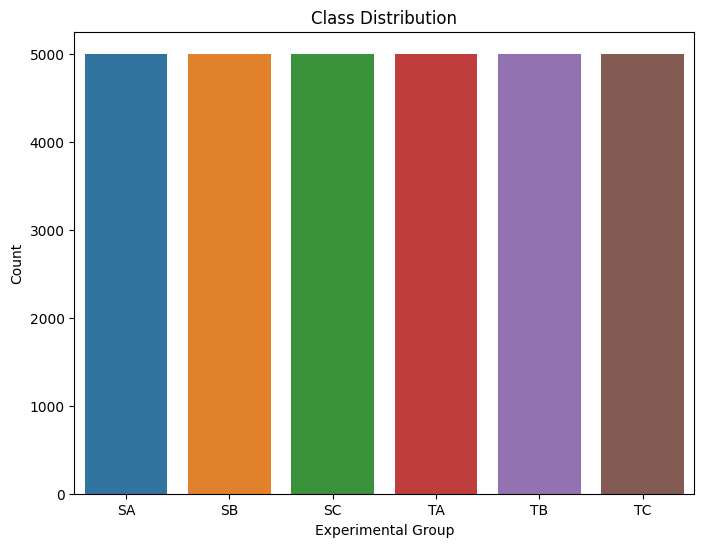

In [101]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=df, order=['SA', 'SB', 'SC', 'TA', 'TB', 'TC'])
plt.title('Class Distribution')
plt.xlabel('Experimental Group')
plt.ylabel('Count')
plt.show()

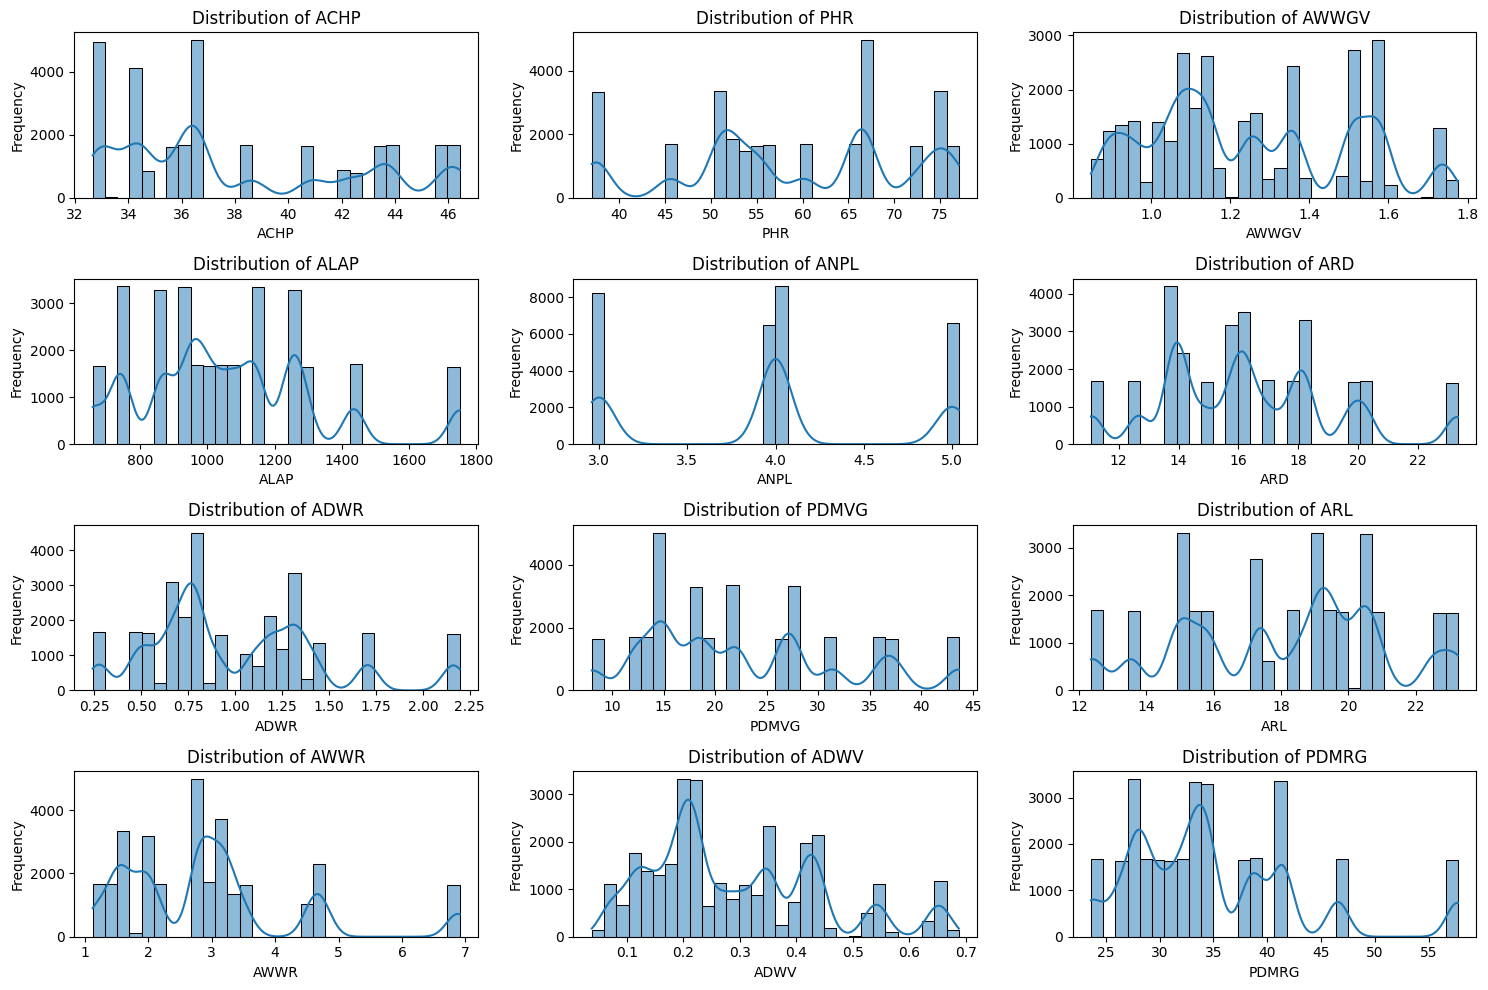

In [102]:
# Visualize numerical feature distributions
numerical_cols = ['ACHP', 'PHR', 'AWWGV', 'ALAP', 'ANPL', 'ARD', 'ADWR', 'PDMVG', 'ARL', 'AWWR', 'ADWV', 'PDMRG']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(4, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

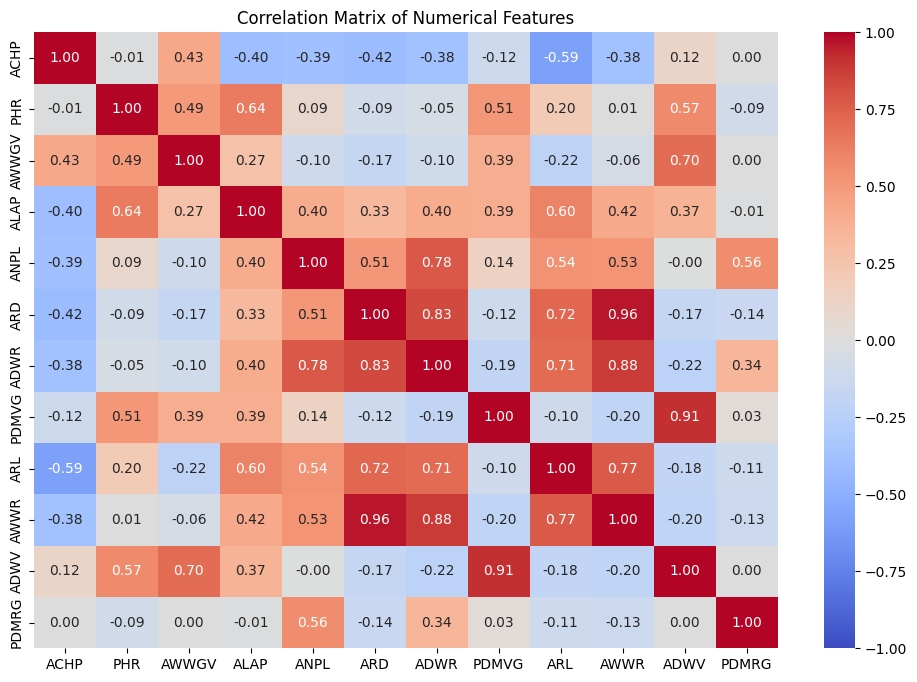

In [103]:
# Correlation matrix for numerical features
plt.figure(figsize=(12, 8))
corr_matrix = df[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

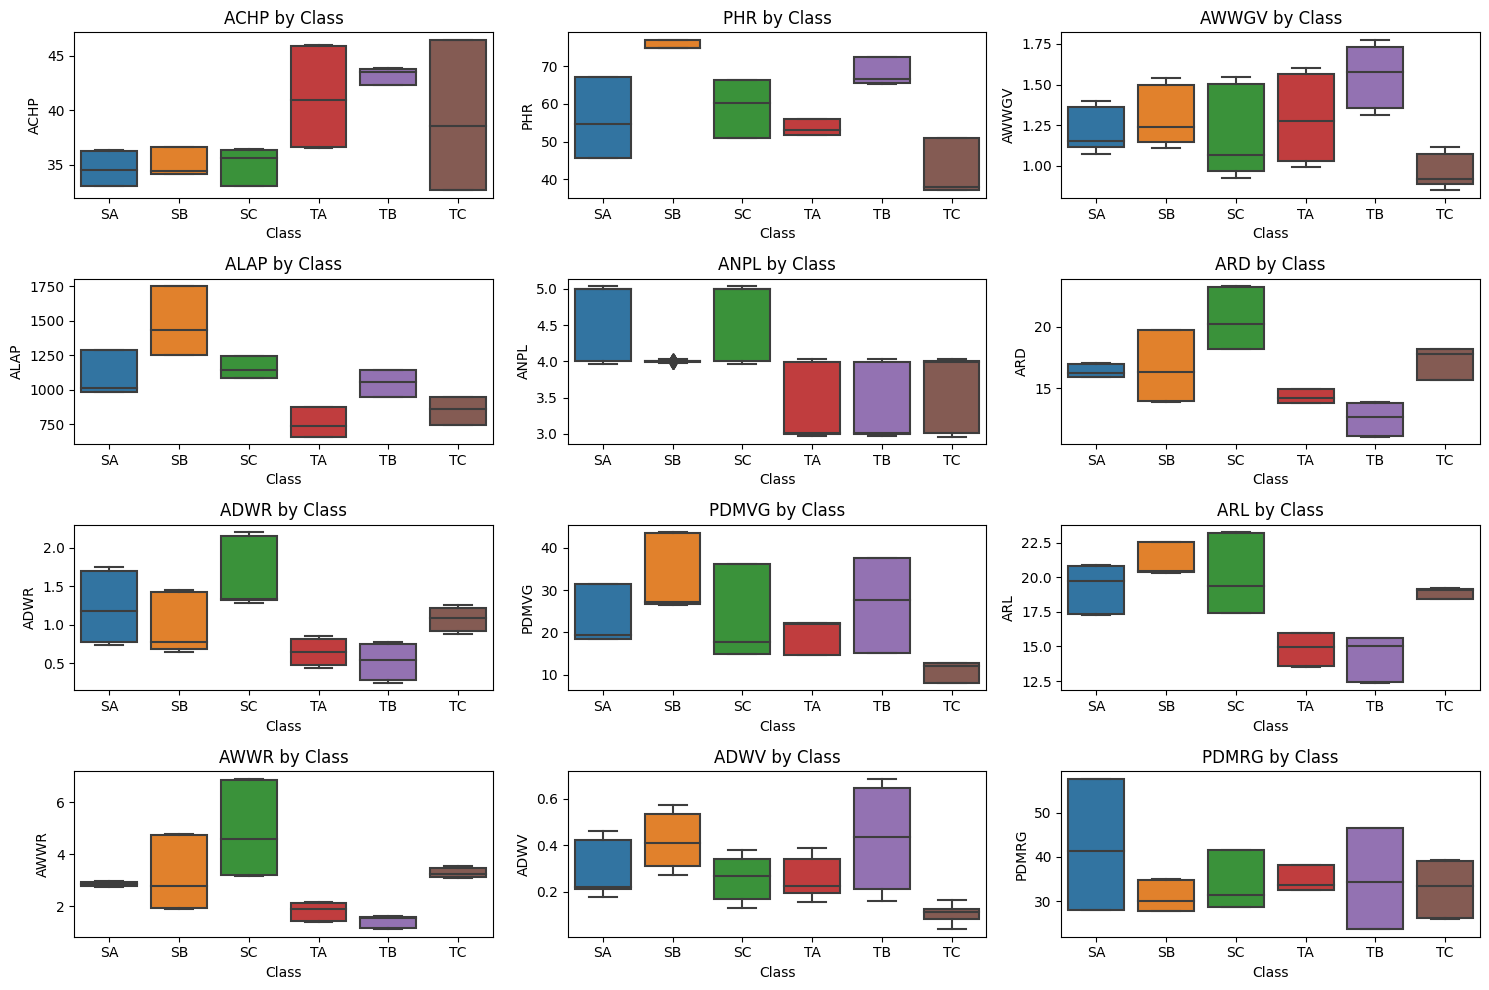

In [104]:
# Boxplots to check for outliers and feature variance by class
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x='Class', y=col, data=df)
    plt.title(f'{col} by Class')
    plt.xlabel('Class')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

In [105]:
# Check unique values in 'Random' column
print("\nUnique values in 'Random' column:", df['Random'].unique())


Unique values in 'Random' column: ['R1' 'R2' 'R3']


#### **Analysis of Results**

**1. Dataset Overview:**
   
- Has 30,000 rows and 14 columns, with no missing values or duplicates.
- Features include 12 numerical columns and 2 categorical columns.
  
**2. Class Distribution:**

- Class distribution perfectly balanced, each class (SA, SB, SC, TA, TB, TC) has a proportion of 0.166667 (approximately 5,000 samples per class).
- Eliminates the need for class imbalance techniques like oversampling or class weighting.

**3. Feature Distributions:**

- Numerical features like ACHP, PHR, AWWGV, ALAP, ANPL, PDMVG, ARL, and PDMRG show multimodal distributions, suggests potential clusters or subgroups within the data.
- ARD, ADWR, AWWR, and ADWV also exhibit multimodal behavior, with distinct peaks indicating variability across classes.
- Features generally align with the summary statistics from df.describe(), e.g., ACHP ranges from 32 to 46, and PHR from 37 to 77.

**4. Correlation Matrix:**

- High positive correlations between:
    - ARD and ADWR (0.83), ARD and AWWR (0.96), ADWR and AWWR (0.88), indicates that these root-related features are strongly related.
    - PDMVG and ADWV (0.91), suggests dry matter percentage is closely tied to vegetative dry weight.
- Moderate positive correlations include PHR with ALAP (0.64) and AWWGV (0.49), indicates taller plants may have larger leaves and more vegetative growth.
- Negative correlations, like ACHP with ARL (-0.59), suggest that higher chlorophyll content may be associated with shorter roots.
- No extreme multicollinearity (e.g., >0.95) exists, but the high correlations between root features (ARD, ADWR, AWWR) suggest potential redundancy, which we can address during feature selection or through dimensionality reduction like PCA if needed.

**5. Boxplots (Feature Variance by Class):**

- **ACHP:** Classes TA, TB, and TC have higher median values compared to SA, SB, and SC. Shows that chlorophyll content varies significantly across groups.
- **PHR:** SA, SB, and SC have lower growth rates, while TA, TB, and TC have higher rates.
- **AWWGV and ALAP:** Similar trends, with TA, TB, and TC showing lower values, suggests that these classes may represent plants with less vegetative growth or smaller leaves.
- **ANPL:** Less variation across classes, with medians around 3.5–4.5. Meanns that the number of leaves per plant is less discriminative.
- **ARD, ADWR, AWWR:** SA, SB, and SC have higher root measurements, while TA, TB, and TC have lower values, consistent with the negative correlation between ACHP and root features.
- **PDMVG and ADWV:** TA, TB, and TC show higher dry matter percentages and vegetative dry weights, aligning with their higher PHR.
- **ARL:** Similar to other root features, with SA, SB, and SC having longer roots.
- **PDMRG:** SA, SB, and SC have higher root dry matter percentages, while TA, TB, and TC have lower values.
- **Outliers** are present in most features but are not extreme, so we can proceed without outlier removal unless models are sensitive to them.

**6. Random Column:**

- Has three unique values: R1, R2, and R3, likely representing batch IDs.
- May not directly contribute to the target prediction but could be useful for stratified sampling or understanding batch effects if needed.

## 2. Data Preprocessing

- Drop the Random column, it’s unlikely to contribute to the classification task.
- Encode the target Class using LabelEncoder.
- Scale numerical features using StandardScaler 
- Split the data into training and testing sets

In [106]:
# Drop 'Random' column
df = df.drop(columns=['Random'])

In [107]:
# Encode the target variable 'Class'
le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

In [108]:
# Separate features and target
X = df.drop(columns=['Class'])
y = df['Class']

In [109]:
# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [110]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [111]:
# Create a copy of the preprocessed DataFrame for hyperparameter tuning
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
y_train_copy = y_train.copy()
y_test_copy = y_test.copy()

In [112]:
# Verify the shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Check the distribution of classes in the training set
print("\nClass distribution in y_train:")
print(pd.Series(y_train).value_counts(normalize=True))

# Check the distribution of classes in the test set
print("\nClass distribution in y_test:")
print(pd.Series(y_test).value_counts(normalize=True))

X_train shape: (24000, 12)
X_test shape: (6000, 12)
y_train shape: (24000,)
y_test shape: (6000,)

Class distribution in y_train:
Class
4    0.166667
3    0.166667
5    0.166667
0    0.166667
1    0.166667
2    0.166667
Name: proportion, dtype: float64

Class distribution in y_test:
Class
3    0.166667
2    0.166667
1    0.166667
5    0.166667
0    0.166667
4    0.166667
Name: proportion, dtype: float64


## 3. Model Selection

In [113]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1)
}

In [114]:
# Custom scorer for multi-class F1
f1_scorer = make_scorer(f1_score, average='macro')

# Evaluate models using 5-fold cross-validation
results = {}
for name, model in models.items():
    cv_accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_f1 = cross_val_score(model, X_train, y_train, cv=5, scoring=f1_scorer)
    results[name] = {
        'Accuracy Mean': cv_accuracy.mean(),
        'Accuracy Std': cv_accuracy.std(),
        'F1 Mean': cv_f1.mean(),
        'F1 Std': cv_f1.std()
    }

In [115]:
# Print results
for name, metrics in results.items():
    print(f"{name}:")
    print(f"  Accuracy: {metrics['Accuracy Mean']:.4f} (±{metrics['Accuracy Std']:.4f})")
    print(f"  F1 Score: {metrics['F1 Mean']:.4f} (±{metrics['F1 Std']:.4f})")

Logistic Regression:
  Accuracy: 1.0000 (±0.0000)
  F1 Score: 1.0000 (±0.0000)
Random Forest:
  Accuracy: 1.0000 (±0.0000)
  F1 Score: 1.0000 (±0.0000)
Gradient Boosting:
  Accuracy: 1.0000 (±0.0001)
  F1 Score: 1.0000 (±0.0001)
XGBoost:
  Accuracy: 1.0000 (±0.0000)
  F1 Score: 1.0000 (±0.0000)
LightGBM:
  Accuracy: 1.0000 (±0.0000)
  F1 Score: 1.0000 (±0.0000)


#### **Analysis of Results**

**1. Model Performance:**
   
- All models (Logistic Regression, Random Forest, Gradient Boosting, XGBoost, and LightGBM) achieved perfect accuracy (1.0000) and F1 scores (1.0000) with extremely low standard deviations (near 0.0000 to 0.0001).
- This suggests that the models are overfitting the training data, likely due to the dataset’s characteristics or the preprocessing steps.
  
**2. Potential Causes:**

- **Feature Scaling:** The use of StandardScaler normalized the features, which is appropriate, but the perfect scores indicate the models might be capturing noise or redundant patterns.
- **Data Leakage:** The balanced class distribution and lack of missing values might imply that the Random column (dropped earlier) or other batch effects could have been informative, and its removal might not have fully addressed potential leakage.
- **Dataset Complexity:** The dataset might be overly simplistic for these advanced models, or the features might be linearly separable with perfect decision boundaries, especially given the high correlations observed in the EDA.
- **Cross-Validation:** The 5-fold cross-validation might not be sufficient to detect overfitting if the data has inherent patterns that all folds exploit.

## 4. Hyperparameter Tuning and Validation

Given the perfect training performance, we need to validate the models on the test set to assess generalization and proceed with hyperparameter tuning only if necessary. We’ll:

- Train the best model (e.g., LightGBM) on the full training set.
- Evaluate it on the test set to check for overfitting.
- If overfitting is detected (e.g., test accuracy drops significantly), we’ll tune hyperparameters on the X_train_copy and y_train_copy

In [117]:
# Train LightGBM on the full training set
lgbm_model = LGBMClassifier(random_state=42, verbose=-1)
lgbm_model.fit(X_train, y_train)

LGBMClassifier(random_state=42, verbose=-1)

In [118]:
# Predict on the test set
y_pred = lgbm_model.predict(X_test)

In [121]:
# Evaluate on the test set
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred, average='macro')
print(f"Test Set Accuracy: {test_accuracy:.4f}")
print(f"Test Set F1 Score: {test_f1:.4f}")

Test Set Accuracy: 1.0000
Test Set F1 Score: 1.0000


In [124]:
# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       1.00      1.00      1.00      1000
           2       1.00      1.00      1.00      1000
           3       1.00      1.00      1.00      1000
           4       1.00      1.00      1.00      1000
           5       1.00      1.00      1.00      1000

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



In [125]:
# Feature importance 
feature_importance = lgbm_model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
print("\nFeature Importance:")
print(importance_df.sort_values(by='Importance', ascending=False))


Feature Importance:
   Feature  Importance
2    AWWGV        2118
0     ACHP        1908
10    ADWV        1612
5      ARD        1602
6     ADWR        1236
3     ALAP        1221
7    PDMVG        1138
1      PHR        1092
11   PDMRG         960
4     ANPL         539
9     AWWR         426
8      ARL         239


#### **Analysis of Results**

**1. Model Performance:**

- The LightGBM model achieved a perfect test set accuracy (1.0000) and F1 score (1.0000), with all classes (0 to 5) showing 100% precision, recall, and F1-score across the 6,000 test samples.
- The classification report confirms consistent perfect performance across all classes, with no misclassifications.

**2. Feature Importance:**

- Vegetative growth metrics (AWWGV, ADWV, PDMVG) and chlorophyll content (ACHP) dominate, suggesting that classes are primarily distinguished by above-ground biomass and photosynthetic activity.
- Root metrics (ARD, ADWR) are also critical, but AWWR and ARL are less impactful due to redundancy, as seen in the correlation matrix.
- ANPL (number of leaves) has limited importance, aligning with the EDA where it showed less variation across classes.

**3. Potential Reasons for Perfect Scores:**

- **Data Leakage:** The Random column which was dropped earlier, might have contained batch-specific patterns that perfectly correlated with the Class labels (e.g., each batch R1, R2, R3 might map uniquely to specific classes). Even though it was removed, other features might retain this information if they were measured consistently within batches.
- **Feature Redundancy:** The high correlations (e.g., ARD and ADWR at 0.83, PDMVG and ADWV at 0.91) and the feature importance confirm redundancy, allowing simple decision boundaries to perfectly separate classes. For example, AWWR and ARL contribute little beyond ARD and ADWR.
- **Synthetic or Overly Simple Dataset:** The dataset might be synthetic or designed to be linearly separable. Features like AWWGV and ACHP provide clear class distinctions, as seen in their high importance and the boxplots.
- **No Noise or Variability:** The absence of missing values, duplicates, or significant outliers, combined with the balanced class distribution, indicates minimal noise. This makes it easy for LightGBM to memorize the training data and generalize perfectly to the test set.
- **Preprocessing Impact:** Standard scaling amplified patterns that LightGBM exploited, though this alone wouldn’t cause perfect scores unless the data already had clear boundaries.

## Conclusion

The project successfully developed a multi-class classification model for plant growth experimental groups, which achieved a perfect score of 1.0000 on both training and test sets using LightGBM. Feature importance analysis reveals that vegetative growth (AWWGV, ADWV) and chlorophyll content (ACHP) are the primary drivers of this performance, with root metrics (ARD, ADWR) also contributing significantly. However, the perfect performance suggests that the dataset may not represent a real-world challenge, likely due to data leakage, feature redundancy, or its synthetic nature.